In [1]:
import pandas as pd
import import_ipynb
import analysis_utils as utils
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

importing Jupyter notebook from analysis_utils.ipynb


In [2]:
# Set pandas formating options
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.width = 2000
pd.options.display.max_columns = 10

#### Step 1. Load and clean Airbnb data for Seattle and Boston


In [3]:
# 1.1. load airbnb data using UDF
data_type = ['calendar'
             , 'listings'
             , 'reviews']

city_type = ['seattle'
             , 'boston']

city_dictionary = utils.load_csv(city_type, data_type, 'data')

In [4]:
# 1.2. create separate dataframes for each city and data set
reviews_df = utils.concatenate_dataframes(city_dictionary, 'reviews')
calendar_df = utils.concatenate_dataframes(city_dictionary, 'calendar')
listings_df = utils.concatenate_dataframes(city_dictionary, 'listings')

# Convert host_since_year to numetic value
listings_df['host_since_year'] = pd.to_numeric(listings_df['host_since_year'], errors='coerce')

#### Step 2. Assess size of the data and the amount of missing data
**1.** Check listing data to use in price prediction excersize


In [5]:
# 2.1.1.  check shape of the listings df
print(listings_df[listings_df['boston'] == 1].shape)
print(listings_df[listings_df['boston'] == 0].shape)
# seattle has slighlty more observations

(3585, 99)
(3818, 99)


In [11]:
# 2.1.2 check missing data in listing df
# create a list of columns that have more than 50% of missing data to drop then later
columns_with_missing_values = utils.check_missing_values(listings_df, 0.5)

                           index  seattle  boston
11                       license     1.00    1.00
18              has_availability     0.00    1.00
26            jurisdiction_names     0.00    1.00
78  neighbourhood_group_cleansed     0.00    1.00
39                   square_feet     0.97    0.98
2                  monthly_price     0.60    0.75
80           monthly_price_float     0.60    0.75
28            weekly_price_float     0.47    0.75
55                  weekly_price     0.47    0.75
3               security_deposit     0.51    0.63
12                         notes     0.42    0.55
42         neighborhood_overview     0.27    0.39
76                    host_about     0.22    0.37
17                       transit     0.24    0.36
13                  cleaning_fee     0.27    0.31
34                         space     0.15    0.29
19        review_scores_accuracy     0.17    0.23
58        review_scores_location     0.17    0.23
49           review_scores_value     0.17    0.23


In [7]:
# 2.1.3. Check missing data in categorical series only
string_columns = list(set(listings_df.select_dtypes(include=['object']).columns)) + ['boston']
utils.check_missing_values(listings_df[string_columns], 0.5)

                               index  seattle  boston
16                jurisdiction_names     0.00    1.00
29      neighbourhood_group_cleansed     0.00    1.00
58                  has_availability     0.00    1.00
10                     monthly_price     0.60    0.75
38                      weekly_price     0.47    0.75
12                  security_deposit     0.51    0.63
41                             notes     0.42    0.55
62             neighborhood_overview     0.27    0.39
27                        host_about     0.22    0.37
57                           transit     0.24    0.36
43                      cleaning_fee     0.27    0.31
45                             space     0.15    0.29
42                       last_review     0.16    0.21
44                      first_review     0.16    0.21
6                         medium_url     0.08    0.17
32                    xl_picture_url     0.08    0.17
59                     thumbnail_url     0.08    0.17
30                     neigh

['jurisdiction_names',
 'neighbourhood_group_cleansed',
 'has_availability',
 'monthly_price',
 'weekly_price',
 'security_deposit',
 'notes']

In [12]:
# 2.1.4. Check missing data in numerical series only
numeric_columns = list(set(listings_df.select_dtypes(include=['int64','float64']).columns))
utils.check_missing_values(listings_df[numeric_columns], 0.5)

                             index  seattle  boston
20                         license     1.00    1.00
32                     square_feet     0.97    0.98
13             monthly_price_float     0.60    0.75
7               weekly_price_float     0.47    0.75
0           review_scores_accuracy     0.17    0.23
21          review_scores_location     0.17    0.23
6              review_scores_value     0.17    0.23
3            review_scores_checkin     0.17    0.23
34       review_scores_cleanliness     0.17    0.23
27     review_scores_communication     0.17    0.23
11            review_scores_rating     0.17    0.23
10               reviews_per_month     0.16    0.21
33                       bathrooms     0.00    0.00
12                        bedrooms     0.00    0.00
17                            beds     0.00    0.00
2              host_listings_count     0.00    0.00
18                 host_since_year     0.00    0.00
19       host_total_listings_count     0.00    0.00
1           

['license', 'square_feet', 'monthly_price_float', 'weekly_price_float']

In [13]:
# 2.1.5. check missing values after droping columns with more than 50 percent of missing values
utils.check_missing_values(listings_df, 0.5)

                           index  seattle  boston
11                       license     1.00    1.00
18              has_availability     0.00    1.00
26            jurisdiction_names     0.00    1.00
78  neighbourhood_group_cleansed     0.00    1.00
39                   square_feet     0.97    0.98
2                  monthly_price     0.60    0.75
80           monthly_price_float     0.60    0.75
28            weekly_price_float     0.47    0.75
55                  weekly_price     0.47    0.75
3               security_deposit     0.51    0.63
12                         notes     0.42    0.55
42         neighborhood_overview     0.27    0.39
76                    host_about     0.22    0.37
17                       transit     0.24    0.36
13                  cleaning_fee     0.27    0.31
34                         space     0.15    0.29
19        review_scores_accuracy     0.17    0.23
58        review_scores_location     0.17    0.23
49           review_scores_value     0.17    0.23


['license',
 'has_availability',
 'jurisdiction_names',
 'neighbourhood_group_cleansed',
 'square_feet',
 'monthly_price',
 'monthly_price_float',
 'weekly_price_float',
 'weekly_price',
 'security_deposit',
 'notes']


**2.** Check calendar data to use in study price seasonality and time trend

In [14]:
# 2.2.1. Check missing data in calendar df
utils.check_missing_values(calendar_df, 0.5) 

         index  seattle  boston
2        price     0.33    0.51
4  price_float     0.33    0.51
0   listing_id     0.00    0.00
1     date_day     0.00    0.00
3    available     0.00    0.00
5         date     0.00    0.00
6    date_year     0.00    0.00
7   date_month     0.00    0.00
8       boston     0.00    0.00


['price', 'price_float']

#### Step 3. Clean data: 
**1.** Remove irrelevant columns and columns where missing values exceed 50 percent in listing_df


In [15]:
# 3.1.1. drop url and scrapping related columns
listings_df = utils.drop_specified_columns('url', listings_df)
listings_df = utils.drop_specified_columns('scrap', listings_df)

In [16]:
# 3.1.2. drop non informative columns
# exclude_colums is the list of columsn that contains information that is not useful in prediction of the price
exclude_columns = ['id'
                , 'host_id'
                , 'host_listings_count'
                , 'host_total_listings_count'
                , 'neighborhood_overview'
                , 'host_neighbourhood'
                , 'host_about'
                , 'transit'
                , 'neighbourhood'
                , 'latitude'
                , 'longitude'
                , 'last_review'
                , 'first_review'
                , 'summary'
                , 'zipcode'
                , 'host_location'
                , 'state'
                , 'country'
                , 'market'
                , 'space'
                , 'cleaning_fee'
                , 'host_acceptance_rate'
                , 'host_response_rate']
try:
    listings_df = listings_df.drop(columns=exclude_columns)
except KeyError:
    print('Columns already deleted')

In [17]:
# 3.1.3. drop columns that have more than 50% of data missing
try:
    listings_df = listings_df.drop(columns=columns_with_missing_values)
except KeyError:
    print('Columns already deleted')

**2.** Replace missing values of numeric columns in listing_df with its mean



In [36]:
# 3.2.1. replace missing numeric values with mean values for each city
numeric_columns = listings_df.select_dtypes(include=['float64','int64']).columns
boston_listing_df = listings_df[listings_df['boston'] == 1].reset_index(drop=True)
seattle_listing_df = listings_df[listings_df['boston'] == 0].reset_index(drop=True)

def fillna_with_mean(numeric_series):
    """
    Function to fill nans of numeric series with its mean
    :param data: numeric series
    :return: numeric series with nans replaced by its mean
    """
    numeric_series = numeric_series.fillna(numeric_series.mean())
    return numeric_series


# fill numeric nans with means
for col in numeric_columns:
    boston_listing_df[col] = fillna_with_mean(boston_listing_df[col])
    seattle_listing_df[col] = fillna_with_mean(seattle_listing_df[col])
    
filled_listings_df = pd.concat([boston_listing_df, seattle_listing_df]).reset_index(drop=True)

# check that numeric columns have nans filled
utils.check_missing_values(filled_listings_df.select_dtypes(include=['float64','int64']), 0.5)  

                             index  seattle  boston
0                reviews_per_month     0.00    0.00
1                 availability_365     0.00    0.00
2                     accommodates     0.00    0.00
3           review_scores_accuracy     0.00    0.00
4   calculated_host_listings_count     0.00    0.00
5                         bedrooms     0.00    0.00
6                   minimum_nights     0.00    0.00
7                        bathrooms     0.00    0.00
8                  availability_30     0.00    0.00
9              review_scores_value     0.00    0.00
10                 availability_90     0.00    0.00
11          review_scores_location     0.00    0.00
12                 availability_60     0.00    0.00
13                  maximum_nights     0.00    0.00
14                 guests_included     0.00    0.00
15           review_scores_checkin     0.00    0.00
16            review_scores_rating     0.00    0.00
17                            beds     0.00    0.00
18          

[]

In [37]:
# 3.2.2. drop records where categorical variables are missing in listing_df

# check what categorical variables have missing values
utils.check_missing_values(filled_listings_df[list(filled_listings_df.select_dtypes(include=['object']).columns) + ['boston']], 0.5)  
# The only column that has missing values is host_response_time
# Only about 14% is missing from each city data
# Since I am interested in the impact of this variable in the price and there are only 14% of missing data 
# I can drop the records with missing data without loosing a lot of variation in the data
filled_cleaned_listings_df = filled_listings_df.dropna()
filled_cleaned_listings_df.shape

                               index  seattle  boston
1                 host_response_time     0.14    0.13
29                     property_type     0.00    0.00
28                              city     0.00    0.00
0             host_identity_verified     0.00    0.00
6                     host_since_day     0.00    0.00
11                         host_name     0.00    0.00
13                  host_since_month     0.00    0.00
16                 host_is_superhost     0.00    0.00
20                        host_since     0.00    0.00
27              host_has_profile_pic     0.00    0.00
2                              price     0.00    0.00
3      require_guest_profile_picture     0.00    0.00
4                experiences_offered     0.00    0.00
5                       country_code     0.00    0.00
7                               name     0.00    0.00
8                           bed_type     0.00    0.00
9                cancellation_policy     0.00    0.00
10                  calendar

(6404, 54)

**3.** Drop irrelevant columns and records with missing values in calendar_df

In [33]:
# 3.3.1. drop irrelevant columns and rows with missing data in calendar_df
calendar_df = calendar_df.drop(columns=['listing_id','date_day','date','available','price'])
calendar_df = calendar_df.dropna().reset_index(drop=True)
# even after dropping missing it is a large dataset
calendar_df.shape

KeyError: "['listing_id' 'date_day' 'date' 'available' 'price'] not found in axis"

#### Step 4. Analyze and Visualize data
**1.** Visualize differences in numeric listing_df data between two


In [21]:
# 4.1. describe all numeric columns in both cities
utils.compare_all_float_columns(filled_cleaned_listings_df)
#Boston has larger minimum_nights mean
#Boston has lower review scores mean
#Boston has higher mean price
#Boston has less beds mean


 Describe reviews_per_month
   index  reviews_per_month_seattle  reviews_per_month-boston
0  count                    3294.00                   3110.00
1   mean                       2.20                      2.09
2    std                       1.73                      1.97
3    min                       0.03                      0.01
4    25%                       0.92                      0.73
5    50%                       2.04                      1.90
6    75%                       2.93                      2.48
7    max                      12.15                     19.15

 Describe availability_365
   index  availability_365_seattle  availability_365-boston
0  count                   3294.00                  3110.00
1   mean                    250.67                   198.77
2    std                    124.27                   136.25
3    min                      0.00                     0.00
4    25%                    138.25                    59.00
5    50%                 

   index  review_scores_checkin_seattle  review_scores_checkin-boston
0  count                        3294.00                       3110.00
1   mean                           9.78                          9.65
2    std                           0.56                          0.68
3    min                           2.00                          2.00
4    25%                           9.79                          9.65
5    50%                          10.00                         10.00
6    75%                          10.00                         10.00
7    max                          10.00                         10.00

 Describe review_scores_rating
   index  review_scores_rating_seattle  review_scores_rating-boston
0  count                       3294.00                      3110.00
1   mean                         94.54                        92.02
2    std                          6.08                         8.12
3    min                         20.00                        20.0

                             mean-seattle  mean-boston
minimum_nights                       2.39         3.15
bedrooms                             1.30         1.26
bathrooms                            1.26         1.23
guests_included                      1.70         1.46
accommodates                         3.39         3.09
reviews_per_month                    2.20         2.09
review_scores_accuracy               9.64         9.44
review_scores_value                  9.45         9.17
review_scores_location               9.61         9.41
review_scores_checkin                9.78         9.65
number_of_reviews                   24.65        21.59
review_scores_communication          9.81         9.65
review_scores_cleanliness            9.57         9.28


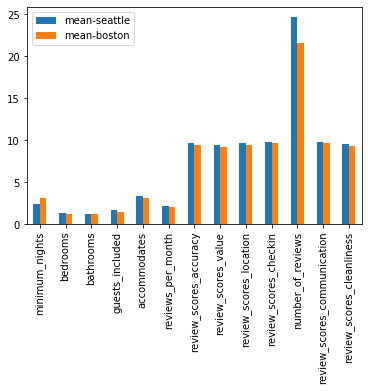

             mean-seattle  mean-boston
price_float        124.62       171.25


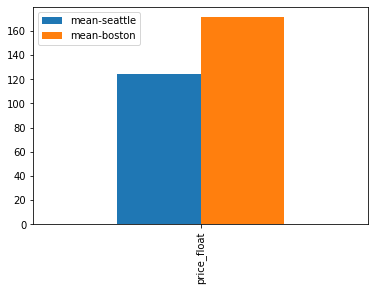

                      mean-seattle  mean-boston
review_scores_rating         94.54        92.02


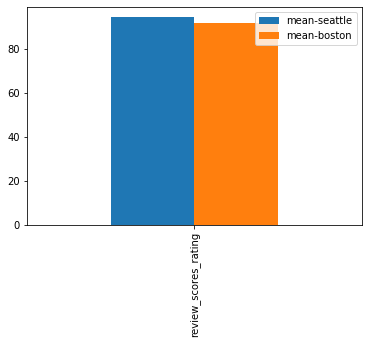

In [22]:
# summarize price, reviews and property attributes in a single summary
# create list of columns containing review string
review_columns = [col for col in filled_cleaned_listings_df.columns if 'review' in col] 

# create list of additional columns of interest
specific_columns = ['minimum_nights'
                   , 'bedrooms'
                   , 'bathrooms'
                   , 'guests_included'
                   , 'accommodates']

# create a combine list of numeric columns of interest
numeric_columns_to_describe = specific_columns + review_columns

# review_scores_rating has different magnitude so should be plotted seprately
numeric_columns_to_describe.remove('review_scores_rating')

# compare selected numeric columns
utils.compare_specified_float_columns(filled_cleaned_listings_df, numeric_columns_to_describe, 'mean')

# compare price
utils.compare_specified_float_columns(filled_cleaned_listings_df, ['price_float'], 'mean')

# compare review score
utils.compare_specified_float_columns(filled_cleaned_listings_df, ['review_scores_rating'], 'mean')

# create list of numeric columns to use in analysis
numeric_columns_to_describe = numeric_columns_to_describe + ['host_since_year', 'review_scores_rating']
# Price mean is higher in Boston but raitings mean is higher in Seattle

**2.** Visualize difference in prices depending on categorical data


In [27]:
# 4.2. describe relationship between price and categorical values between two cities

# create list of string columns that have up to 6 different values in oder to make categorical predictors
values_freq = {}
for col in filled_cleaned_listings_df.select_dtypes(include=['object']):
    values_freq[col] = len(filled_cleaned_listings_df[col].drop_duplicates())
values_freq = {k: v for k, v in sorted(values_freq.items(), key=lambda item: item[1], reverse=False)}

# judjing by the amount of the distinct values in the categorical columns it makes sense to use only those with
# less of 6 distinct values as columns with more distinct values would create 
# a large amount of dimentions while not adding much to explanatory power
values_freq = {k: v for k, v in filter(lambda item: 1 < item[1] < 6, values_freq.items())}
categorical_columns_to_describe = set(values_freq.keys())
print(categorical_columns_to_describe)

{'room_type', 'bed_type', 'host_response_time', 'cancellation_policy', 'instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'require_guest_phone_verification', 'require_guest_profile_picture', 'host_is_superhost', 'is_location_exact'}


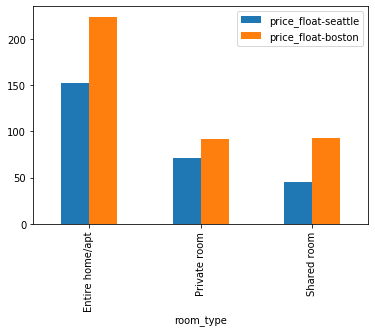

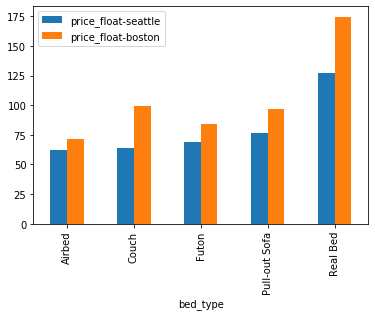

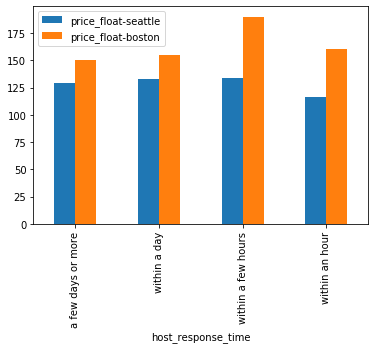

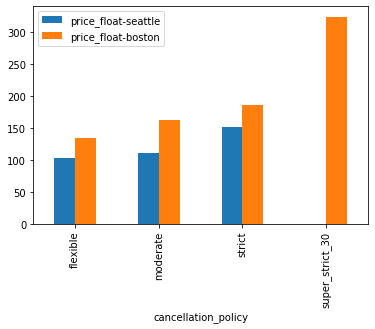

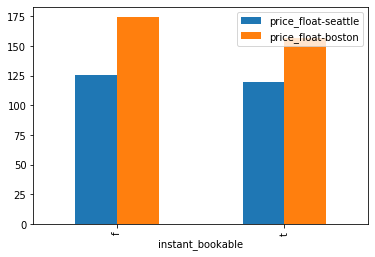

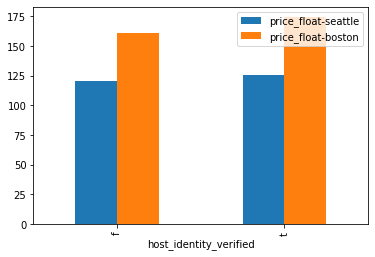

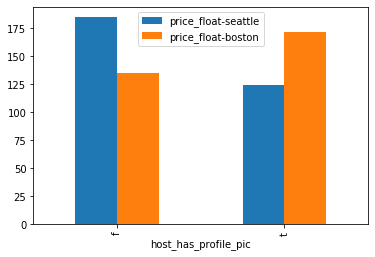

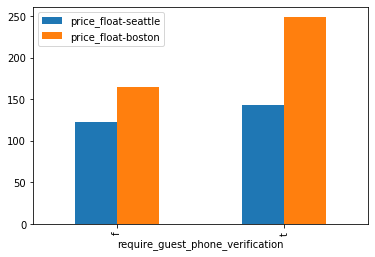

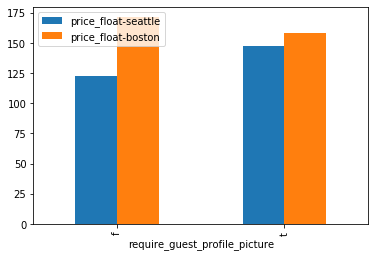

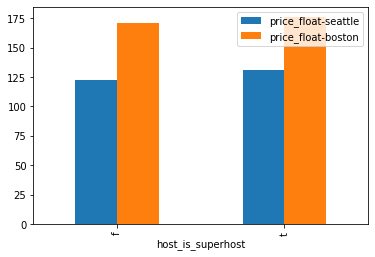

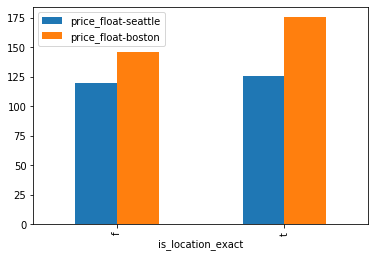

In [24]:
# compare numeric data across 2 cities grouping on each categorical column of interest
for col in categorical_columns_to_describe:
    utils.compare_grouby_results(filled_cleaned_listings_df, [col], ['price_float'], 'mean')
#Boston has a premium for fast responses but not for the fastest
#Boston has super stric policy -> the stricter the policy the more expensive
#Super host has little effect
#Airbeds in seattle seem to be more appreciated than couches

In [28]:
print(categorical_columns_to_describe)

{'room_type', 'bed_type', 'host_response_time', 'cancellation_policy', 'instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'require_guest_phone_verification', 'require_guest_profile_picture', 'host_is_superhost', 'is_location_exact'}


**3.** Create dummies for selected categorical data in listing_df


In [38]:
# 4.3. create dummies for selected categorical variables
# keep only the columns of interest
filled_cleaned_listings_df = filled_cleaned_listings_df[['boston', 'price_float'] + list(numeric_columns_to_describe) + list(categorical_columns_to_describe)]

for col in categorical_columns_to_describe:
    # for each cat add dummy var, drop original column
    filled_cleaned_listings_df = pd.concat([filled_cleaned_listings_df.drop(col, axis=1)
                                        , pd.get_dummies(filled_cleaned_listings_df[col]
                                                         , prefix=col, prefix_sep='_', drop_first=True)], axis=1)


**4.** Create dummies in calendar_df

In [39]:
# 23. Create city, year, city-year interaction dummies in calendar_df
calendar_df['2017_year'] = np.where(calendar_df['date_year'] == '2017', 1, 0)
calendar_df['2017_year_boston'] = calendar_df['2017_year'].multiply(calendar_df['boston'])

In [48]:
#Most of Seattle data is coming from 2016 while most of Boston data is from 2017
calendar_df.groupby(['boston','2017_year'])['date_month'].value_counts()

boston  2017_year  date_month
0       0          12            87061
                   03            83938
                   10            82438
                   11            81780
                   05            79971
                   09            77246
                   06            77244
                   08            76347
                   04            76037
                   07            74222
                   02            73321
                   01            59239
        1          01             5698
1       0          12            60997
                   11            58888
                   10            46345
                   09            24401
        1          01            63181
                   02            56810
                   08            55561
                   03            55181
                   07            54963
                   05            53600
                   06            52731
                   04            5

#### Step 5. Model data

**1.** Run linear regression on listings data study the predictors of the prices in two cities

In [40]:
# 5.1.1. Check what city is on average more expensive
city_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'])
city_results['coefficients'].head()
#Boston is more expensive

,Coefficient
boston,46.81


In [41]:
print(city_results['r2_test'])
# Boston seem to be a more expensive city but just having one regressor does not explain much of price volatility

0.05002210382935135


In [42]:
# 5.1.2. Check if reviews are stronger price predictors than bed and bathrooms
numeric_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], ['boston'] + numeric_columns_to_describe)
numeric_results['coefficients'].head(len(numeric_columns_to_describe) + 1)
# Boston remains a strong predictor of price even holding everything else constant
# Bedrooms, accomodates and bathrooms are as stronger predictors than reviews but score of location matters a lot as well
# Raiting does not matter
# Value score is negaative as expected because if signals a good deal
# Having a host with longer experience does not increase prices

,Coefficient
boston,59.12
review_scores_location,24.57
bedrooms,22.41
bathrooms,21.59
accommodates,19.83
review_scores_cleanliness,10.13
guests_included,2.53
review_scores_rating,0.82
review_scores_accuracy,0.68
minimum_nights,0.15


In [43]:
print(numeric_results['r2_test'])
# Boston is a strong predictor of price, quality of location is also important as well as size of the appartment

0.5064806505620368


In [44]:
# 5.1.3. Check if categorical values are stronger predictors than numeric predictors
columns_of_interest = list(filled_cleaned_listings_df.columns)
columns_of_interest.remove('price_float')
total_results = utils.run_linear_regression(filled_cleaned_listings_df, ['price_float'], columns_of_interest)
total_results['coefficients'].head(len(columns_of_interest)+1)
# Phone verification is associated with more expensive accomodations
# Couch is more expensive than a real bed
# Host that replies in couple of hours earns more than host replyiong within an hour? 
# Number of reviews have negative effect on price

,Coefficient
cancellation_policy_super_strict_30,130.30
boston,55.45
bedrooms,29.04
bathrooms,28.82
bed_type_Couch,21.14
review_scores_location,15.97
require_guest_phone_verification_t,12.81
host_is_superhost_t,12.02
bed_type_Real Bed,10.80
accommodates,9.11


In [45]:
print(total_results['r2_test'])

0.5698920359761256


**2.** Run linear regression on calendar data to see appartment price seasonality and time trend

In [46]:
# 5.2.1. Check if prices decreased in 2017
columns_of_interest = ['2017_year', 'boston', '2017_year_boston']
trends_results = utils.run_linear_regression(calendar_df, ['price_float'], columns_of_interest)
trends_results['coefficients'].head(len(columns_of_interest)+1)
# Boson is +75 in 2016
# seattle prices decreased by 2 dollars in 2017
# Boston prices decreased  by about 21 dollars in 2017

,Coefficient
boston,75.32
2017_year,-1.94
2017_year_boston,-19.14


In [49]:
# 5.2.2. create monthly dummies to check what is the best month to com
monthly_calendar_df = pd.concat([calendar_df.drop('date_month', axis=1)
                            , pd.get_dummies(calendar_df['date_month']
                                             , prefix='month', prefix_sep='_', drop_first=True)], axis=1)
monthly_calendar_df = monthly_calendar_df.drop(columns=['date_year'])
columns_of_interest = [col for col in monthly_calendar_df.columns if 'month_' in col] 

In [50]:
# 5.2.3. Check what month is cheapest for tourists
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , columns_of_interest + ['boston','2017_year','2017_year_boston'])
monthly_results['coefficients'].head(len(columns_of_interest)+3)
# The sign of 2017_year flips to positive 
# suggeting that seattle prices increased in 2017 in comparison to 2016 rather tahn dropped
# the reason is that now we control for seasonality and previously we saw the effect of 
# having only relatively cheaper winter months for 2017 seattle dataset

,Coefficient
boston,77.70
month_07,25.09
month_09,25.06
month_08,24.48
month_06,20.15
month_10,18.48
month_05,14.72
month_04,13.19
2017_year,10.95
month_11,6.23


In [51]:
# 5.2.4. Check what month is cheapest for tourists separately in Boston and Seattle
# list of month dummy columns
monthly_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
# create interactions between boston dummy and month dummies
for col in monthly_columns:
    monthly_calendar_df['boston_' + col] = monthly_calendar_df['boston']*monthly_calendar_df[col]

In [52]:
# list of interaction columns
monthly_interaction_columns = [col for col in monthly_calendar_df.columns if 'month_' in col]
# run linear regression
monthly_results = utils.run_linear_regression(monthly_calendar_df, ['price_float']
                                              , monthly_interaction_columns + ['boston'])
# regression coeficients
monthly_results['coefficients'].head(len(monthly_interaction_columns)+3)

,Coefficient
boston,59.83
boston_month_10,36.93
boston_month_09,33.95
month_07,28.94
month_08,27.47
month_06,24.75
month_09,20.46
month_05,16.65
month_12,14.20
month_10,13.73


In [53]:
# 5.2.5. combine coefficients for Seattle and Boston to infere overall change of prices in Boston in comparison to January
# sort coefificients_df to have boston and seattle coefficients distinctly
coefficients_df = monthly_results['coefficients'].sort_index()
# select only boston coefficients, reset index so boston-month will match seattle-month on index
boston_coefficients_df = coefficients_df[coefficients_df.index.str.contains('boston') 
                                         & (coefficients_df.index != 'boston')].reset_index(drop=True)
# select only seattle coefficients, reset index so boston-month will match seattle-month on index
seattle_coefficients_df = coefficients_df[~coefficients_df.index.str.contains('boston')].reset_index(drop=True)

In [54]:
# merge seatle and boston data
seasonality_df = boston_coefficients_df.merge(seattle_coefficients_df, left_index=True, right_index=True)
# rename index somit is more user friendly names
seasonality_df.index = ['Feb','March','April','May','June','July','Aug','Sep','Oct','Nov','Dec']

In [55]:
# rename columns
seasonality_df.columns = ['Season_Impact_Boston', 'Season_Impact_Seattle']
# the comparison base for interaction dummies is January in Seattle, 
# other coefficients is the difference from January in Seattle
# so coefficient on Boston is the difference in price between Boston and Seattle in January
# difference between Seattle Jan and August is coefficient on month_8
# difference between Boston Jan and August is sum of coefficients on month_8 and boston_month_08
# so to compare seasonality I need to compute total seasonality impact in Boston
seasonality_df['Season_Impact_Boston'] = seasonality_df['Season_Impact_Boston'] + seasonality_df['Season_Impact_Seattle']

In [56]:
# Sort values for Boston
seasonality_df[['Season_Impact_Boston']].sort_values('Season_Impact_Boston').head(11)

,Season_Impact_Boston
Feb,-1.82
March,-0.50
Dec,9.55
May,11.84
June,13.33
April,14.97
July,19.60
Nov,19.68
Aug,20.11
Oct,50.67


In [57]:
# Sort values for Seattle
seasonality_df[['Season_Impact_Seattle']].sort_values('Season_Impact_Seattle').head(11)         

,Season_Impact_Seattle
Feb,1.54
March,5.82
April,11.96
Nov,13.03
Oct,13.73
Dec,14.20
May,16.65
Sep,20.46
June,24.75
Aug,27.47
